# Introduction

This tutorial is going to walk you through the optimization of using the bandit tree algorithms. We take the multi-tree algorithm as an example. The single-tree algorithm can be similarly implemented.

You can customize your own objective functions and optimize them after the tutorial.

# Objective function

## Definition 

We take the [Schwefel](https://www.sfu.ca/~ssurjano/schwef.html) as an example.  
$f(x)=418.9829\times d - \sum_{i=0}^d x_i \sin(\sqrt(|x_i|)) $  
where $d$ is the dimension of the optimization problem; $x = [x_1, x_2, ..., x_d] $ is the $d$-dimensional input. 


In [1]:
import numpy as np
# define the funciton. You can define your own funtion like this. 
def schwefel(x):
    # https://www.sfu.ca/~ssurjano/schwef.html
    # http://benchmarkfcns.xyz/benchmarkfcns/schwefelfcn.html
    x = np.asarray_chkfinite(x)
    n = len(x)
    return 418.9829 * n - sum(x * np.sin(np.sqrt(np.abs(x))))

## Visualization

A 3-D plot of the Schwefel function is shown below.

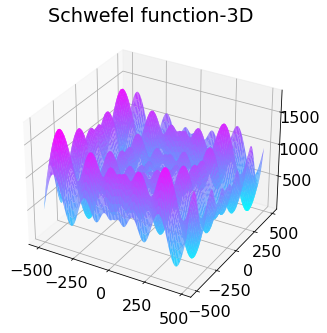

In [2]:
# we have given an example of creating a 3-d plot in fun_2dim.py 
import matplotlib.pylab as plt
%matplotlib inline
from dbtpy.funs.fun_2dim import Schwefel, draw_pic
X, Y, Z, z_max, title = Schwefel(is2Show=True)
z_min = None
draw_pic(X, Y, Z, z_max, title, z_min)

# Multi-tree

## import packages

In [3]:
#-- the multi-tree bandit optimization algorithm
from dbtpy.dbtrees.multi_tree import BanditTreeSearch as BTS
#-- the single-tree bandit optimization algorithm 
# from dbtpy.dbtrees.single_tree import BanditTreeSearch as BTS
#-- use the tools to save important info. into a txt file.
from dbtpy.tools.file_tools import get_time, save_dict, read_dict
#-- we have already define the schwefel function previously
# from dbtpy.funs.fun_ndim import schwefel
#-- some other common packages
import numpy as np
import time
import os
import matplotlib.pyplot as plt

## Define the optimization dictionaries

### The objective function dictionary

In [4]:
#------ the objective function dictionary
obj_dict = {} # you can store different objective functions all together into this dictionary.

#-- the first way: if the domains are all the same for all dimensions.
obj_dict['schwefel_2d'] = {'obj_fun':schwefel, # the objective function defined previously
                           'vars_and_bounds':{'x':(-500,500), # the variable and the bound
                                             'dim':2 }, # the number of dimensions
                           'opt_mode':'min'} # 'min' for minimization problems;'max'for maximization problems
                                             # 'min' by default
    
#-- the second way: different dimensional variables have different bounds
#- give the lower bound list and the upper bound list, separately
# obj_dict['schwefel_2d'] = {'obj_fun':schwefel, # the objective function defined previously
#                             'vars_and_bounds':{'x':[(lb1,lb2, ..,lb10),
#                                                     (ub1,ub2,...,ub10) ],
#                             'dim':10}
                              # 'min' by default. 

### The algorithm dictionary

In [5]:
#---- the algorithm dictionary
alg_save_dict = {}
#-- give a name to the algorithm. You can name it as you like. 
alg_save_dict['alg_name'] = 'dbt_multi_ts'
#-- the path to save the optimization results 
alg_save_dict['save_path'] = r'tutorial\multi_tree_optim'
#-- the file name. We save the content into a txt file.
alg_save_dict['save_fileName'] = 'tutorial_dbt_multi_'+ get_time() + '.txt'
#-- the number of repeations of the experiments. 
alg_save_dict['exp_num'] = 1
#-- the tree depth, which is dependant on the desired resolution
alg_save_dict['tree_depth'] = 15
#--if 'ts2' or 'ts', we use the mult-tree with the standard thompson sampling
#--if 'ts3' or 'rts', we use the mult-tree with the resphared thompson sampling
alg_save_dict['solver_type'] = 'ts3' 
#-- the number epoch of the optimization 
alg_save_dict['epoch_num'] = 1000
#-- the types of optimization information you want to save 
#- var_try_list: 
#      a list of dictionaries containing the variables being tried over the course and 
#      the corresponding values of the objective function
#- var_opt_list
#      a list of dictionaries containing the optimal variables being tried over the course and 
#      the corresponding optimal values of the objective function
#- obj_value: the fitness over time 
#- tree_shape: the shape of the tree 
#- succ_info: information of the successful trials of the Bernoulli bandit model 
alg_save_dict['opt_info'] = { obj:{'var_try_list':[],
                                   'var_opt_list':[],
                                   'tree_shape':[], # not applicable in singal-tree
                                   'succ_info':[], # not applicable in singal-tree
                                   'obj_value':[],
                                   'obj_mean':[],
                                   'obj_std':[] } 
                                    for obj in obj_dict}
#-- running time of the algorithm 
alg_save_dict['run_time'] = { obj:[]  for obj in obj_dict}

## Run the optimization algorithm

In [6]:
# create the instance of the optimiation algorithm
bts = BTS(tree_depth = alg_save_dict['tree_depth'])
###########################################################################
#-- run opt exp
for i in range(alg_save_dict['exp_num'] ):
    for j, obj_str in enumerate(obj_dict):
        time_start=time.time()
        bts.solve(solver_type = alg_save_dict['solver_type'],
                     epoch_num = alg_save_dict['epoch_num'] , 
                            **obj_dict[obj_str]) # **unpack the keyword arguments
        time_end=time.time()
        alg_save_dict['run_time'][obj_str].append(time_end - time_start)
        alg_save_dict['opt_info'][obj_str]['var_try_list'].append(bts.var_try_list)
        alg_save_dict['opt_info'][obj_str]['var_opt_list'].append(bts.var_opt_list)
        # not applicable in singal-tree
        alg_save_dict['opt_info'][obj_str]['tree_shape'].append(bts.tree_shape())
        # not applicable in singal-tree
        alg_save_dict['opt_info'][obj_str]['succ_info'].append(bts.success_info())
        alg_save_dict['opt_info'][obj_str]['obj_value'].append([opt['objValue'] for opt in bts.var_opt_list])

###########################################################################
#-- a simple data process
for obj_str in obj_dict:
    objValues = alg_save_dict['opt_info'][obj_str]['obj_value']
    alg_save_dict['opt_info'][obj_str]['obj_mean'] = list(np.mean(objValues, axis = 0))
    alg_save_dict['opt_info'][obj_str]['obj_std'] = list(np.std(objValues, axis = 0))

###########################################################################
#-- save & read data 
savePath = os.path.join(alg_save_dict['save_path'], alg_save_dict['save_fileName'] )
save_dict(alg_save_dict,  savePath )

100%|██████████| 999/999 [00:00<00:00, 4451.84it/s]

The Optimal =  {'x0': 420.97074722003754, 'x1': 420.97674491453176, 'objValue': 3.4033153951895656e-05} 



## Visualization I
Rough visualization

In [7]:
#-- running time 
print(alg_save_dict['run_time'])

{'schwefel_2d': [0.23237991333007812]}


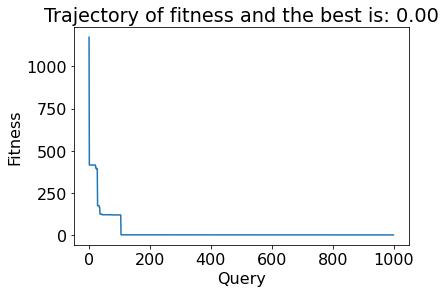

In [8]:
#-- show fitness
bts.visualization(sim_update_show=True)
#-- the plot can be revored using alg_save_dict['opt_info'][obj_str]['var_opt_list']

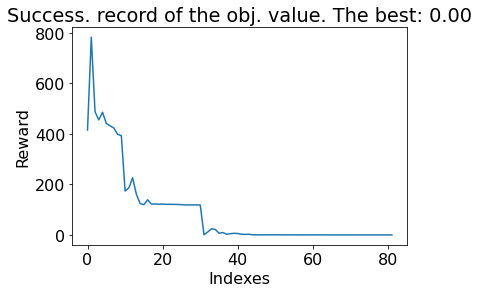

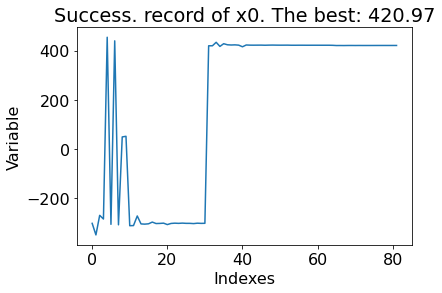

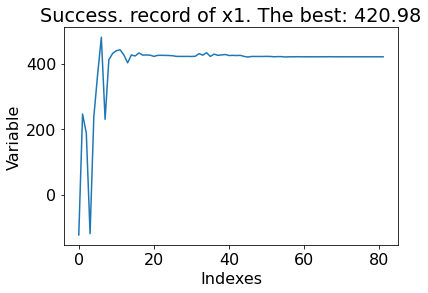

In [9]:
#-- show successful information of the Bernoulli bandit model
# not applicable in singal-tree
bts.visualization( tree_update_show=True)
#-- the plots can be revored using alg_save_dict['opt_info'][obj_str]['succ_info']

100%|██████████| 2001/2001 [00:00<00:00, 2727.56it/s]


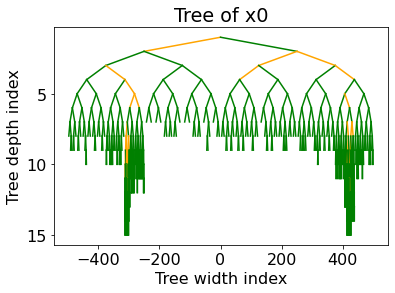

100%|██████████| 2001/2001 [00:00<00:00, 2666.17it/s]


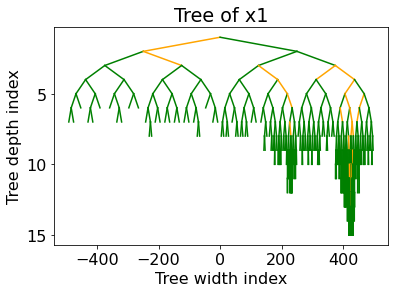

In [10]:
# -- show the tree structure
# not applicable in singal-tree
bts.visualization( tree_shape_show=True)
# the plots can be revored using alg_save_dict['opt_info'][obj_str]['tree_shape']

# Visualization II
better visualization

## Read the saved file

In [1]:
savePath = r'tutorial\multi_tree_optim\tutorial_dbt_multi_20220531154431.txt'
from dbtpy.tools.file_tools import  read_dict
alg_read_dict = read_dict(savePath) 
print(alg_read_dict.keys())

dict_keys(['alg_name', 'save_path', 'save_fileName', 'exp_num', 'tree_depth', 'solver_type', 'epoch_num', 'opt_info', 'run_time'])


## Plot the fitness curve

In [2]:
from dbtpy.tools.visual_tools import plot_fitness
print(alg_read_dict['opt_info'].keys())

dict_keys(['schwefel_2d'])


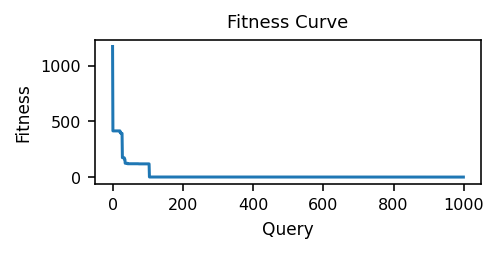

The optimal resutls:  {'x0': 420.97074722003754, 'x1': 420.97674491453176, 'objValue': 3.4033153951895656e-05}


In [3]:
obj_str = 'schwefel_2d'
exp_id = -1
var_opt_list = alg_read_dict['opt_info'][obj_str]['var_opt_list'][exp_id]
plot_fitness(var_opt_list)
print('The optimal resutls: ', var_opt_list[-1])

## plot successful information

In [4]:
from dbtpy.tools.visual_tools import plot_sInfo
succ_info =  alg_read_dict['opt_info'][obj_str]['succ_info'][exp_id]

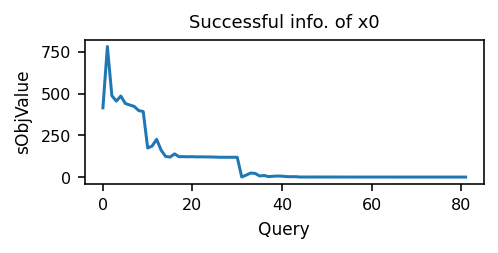

In [5]:
plot_sInfo(succ_info, dimName= 'x0', yName='sObjValue')

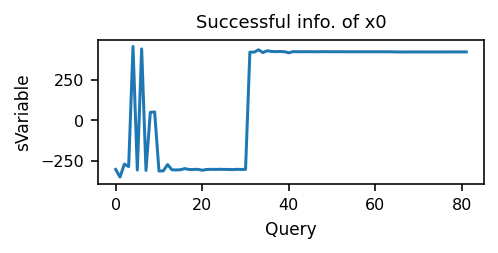

In [6]:
plot_sInfo(succ_info, dimName= 'x0', yName='sVariable')

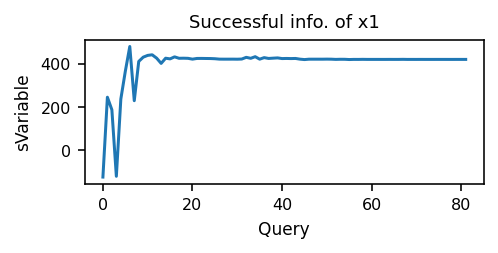

In [7]:
plot_sInfo(succ_info, dimName= 'x1', yName='sVariable')

100%|██████████| 2000/2000 [00:00<00:00, 2805.80it/s]


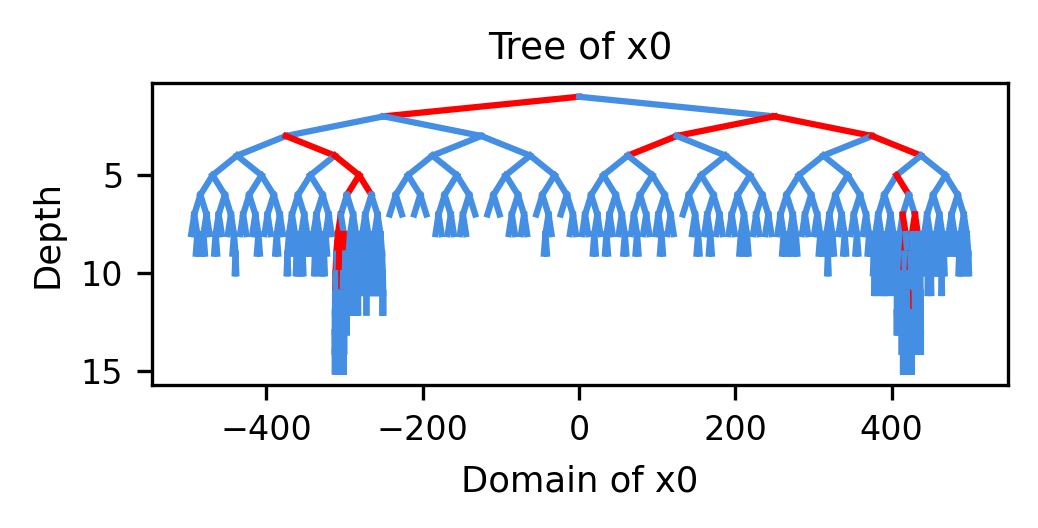

100%|██████████| 2000/2000 [00:00<00:00, 2587.55it/s]


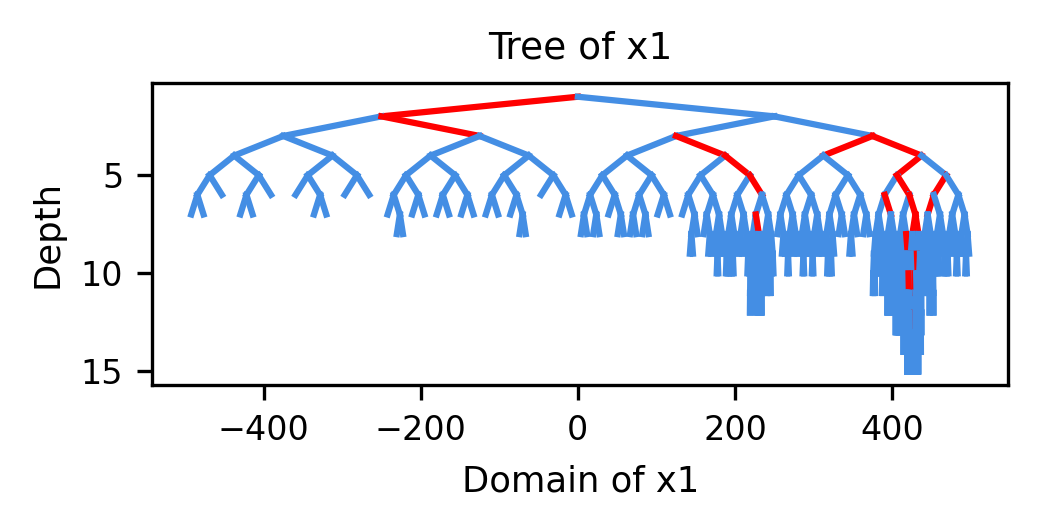

In [8]:
from dbtpy.tools.visual_tools import plot_shape
tree_shape =  alg_read_dict['opt_info'][obj_str]['tree_shape'][exp_id]
for treeID  in tree_shape:
    plot_shape(branches_list = tree_shape[treeID ] , treeID = treeID , dpi=300,
                s_color = 'red', f_color = 'xkcd:dark sky blue')